In [4]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec, patches
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [6]:
# SHORTER
MORSE_CODE_DICT = {'1':'.-', '2':'-...', 
                    '3':'-.-.', '4':'-..', '5':'.', 
                    '6':'..-.', '7':'--.', '8':'....', 
                    '9':'..', '0':'.---',}

In [7]:

print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())


[1 0 1 1 1 0 0 0] 1
[1 1 1 0 1 0 1 0 1 0 0 0] 2
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] 3
[1 1 1 0 1 0 1 0 0 0] 4
[1 0 0 0] 5
[1 0 1 0 1 1 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 0 0] 7
[1 0 1 0 1 0 1 0 0 0] 8
[1 0 1 0 0 0] 9
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 0


(490, 2)


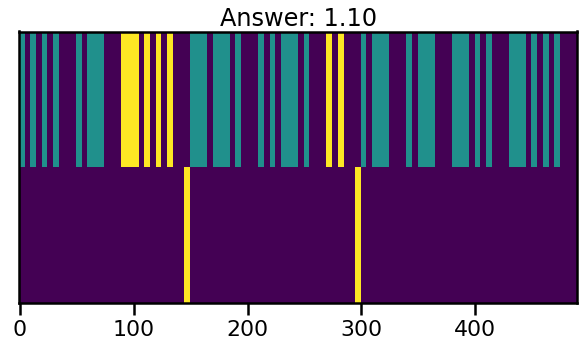

In [8]:
def gen_item(samples=10, scale=5, target_scale=.1, display=False):
    # We can tests 1s the same length as the items added together or 1 at the end only.
    keys = morse_code_numpy.keys()
    dim1 = []
    dim2 = []
    half = int(samples / 2)
    added_indexes = [np.random.randint(half),  
                     np.random.randint(half, samples)]
    
    answer = 0
    for s in range(samples):
        # Grab Random Morse Code Letter
        k = random.sample(keys, 1)[0]
        mcl = morse_code_numpy[k]
        Mmcl = mcl.repeat(scale)
        dim1.append(Mmcl[:, np.newaxis])
        if s in added_indexes:
            
            # dim2.append(np.ones(Mmcl.shape[0])[:, np.newaxis])
            temp = np.zeros(Mmcl.shape[0])[:, np.newaxis]
            temp[-scale:] = 1.0
            if display:
                    temp = temp * 2.0
            #temp[-1] = 1.0 # TRY THIS AT SOME POINT
            dim2.append(temp)
            answer += int(k)
            if display:
                dim1[-1] = dim1[-1]*2.0
        else:
            dim2.append(np.zeros(Mmcl.shape[0])[:, np.newaxis])
    inp = np.concatenate([np.concatenate(dim1, axis=0),
                          np.concatenate(dim2, axis=0)], axis=1)
    
    target = np.array([answer])
    return inp, target*target_scale
inp, tar = gen_item(10, 5, .1, display=True)
print(inp.shape)
plt.figure(figsize=(10,5))
plt.imshow(inp.T,aspect='auto', interpolation='none')
plt.title("Answer: {:.2f}".format(tar[0]))
plt.yticks([])
plt.savefig(join('figs', 'adding_morse_example'), dpi=100)

In [9]:
items = np.load('generated_adding_morse.npy', allow_pickle=True)

In [10]:
TCN_perfs = pd.read_pickle(join("perf", "tcn_morseadding_test.dill"))
SITH_perfs = pd.read_pickle(join("perf", "sithcon_morseadding_test.dill"))
print(SITH_perfs.head())

   test_perf  rate
0   0.611296     1
1   0.068559     2
2   0.006122     3
3   0.000922     4
4   0.000666     5


In [11]:
with open(join('perf','display_examples.dill'), 'rb') as handle:
    display_examples = pickle.load(handle)

In [12]:
ystart = -.6
height = 2.2
boxes = [[[36.7, ystart, 11, height,], [83, ystart, 7, height]],
         [[12.5, ystart, 9.5, height,],[76.5, ystart, 17.6, height,]],
         [[21, ystart, 11.0, height,],[91, ystart, 17.3, height]],
         [[19, ystart, 11.0, height,],[60.8, ystart, 17.1, height,]],
         [[-1.4, ystart, 11.4, height,],[85, ystart, 11.2, height]]
]

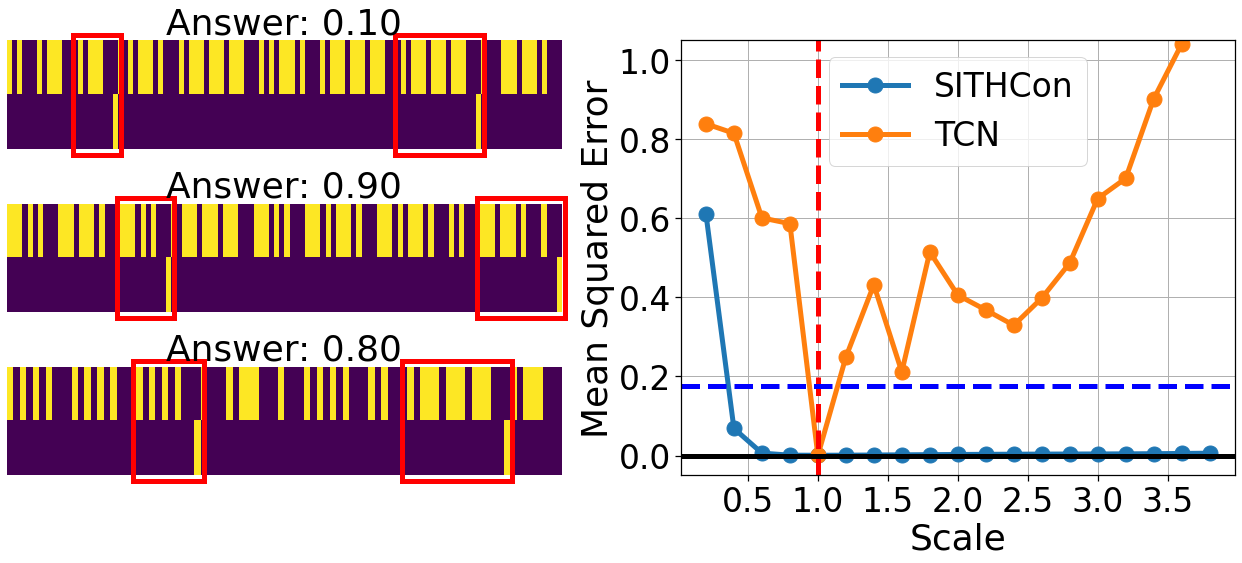

In [15]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=3):
    fig = plt.figure(figsize=(22,8), )
    spec = gridspec.GridSpec(nrows=3, ncols=4, hspace=.5, wspace=.55,
                             figure=fig)
    for i, de in enumerate(display_examples[1:-1]):
        ax = fig.add_subplot(spec[i, :2])
        Trainscale = 5

        ax.imshow(de[0].T,aspect='auto', interpolation='none')
        ax.set_title("Answer: {:.2f}".format(de[1][0]))
        ax.set_yticks([])
        ax.set_xticks([])
        bb = boxes[i+1][0]
        ax.set_axis_off()
        rect = patches.Rectangle((bb[0], bb[1]),bb[2],bb[3], linewidth=5, 
                                 edgecolor='r', facecolor='none', clip_on=False)
        ax.add_patch(rect)
        bb = boxes[i+1][1]
        rect = patches.Rectangle((bb[0], bb[1]),bb[2],bb[3], linewidth=5, 
                                 edgecolor='r', facecolor='none', clip_on=False)
        ax.add_patch(rect)
    """ax = fig.add_subplot(spec[1])
    inp, tar = gen_item(10, 5, .1)
    print(inp.shape)
    ax.imshow(inp.T,aspect='auto', interpolation='none')
    ax.set_title("Answer: {:.2f}".format(tar[0]))
    ax.set_yticks([])
    ax.set_xticks([])"""
    
    ax = fig.add_subplot(spec[:, 2:,])
    plt.plot(SITH_perfs.rate/Trainscale, SITH_perfs.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.plot(TCN_perfs.rate/Trainscale, TCN_perfs.test_perf, marker='o',
            linewidth=lw, ms=ms)
    plt.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms)
    plt.axhline(.175, color='blue', linestyle='--', linewidth=lw, ms=ms)
    plt.axhline(0, color='black',
            linewidth=lw, ms=ms)
    plt.ylim(-.05, 1.05)
    #plt.xlim(.1, 10)
    #plt.xscale('log')
    plt.grid()
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Scale')
    plt.legend(['SITHCon', 'TCN'])
plt.savefig(join('figs', 'morse_addition_test.pdf'), dpi=100)
plt.savefig(join('figs', 'morse_addition_test.png'), dpi=100)